In [32]:
import numpy as np
import pandas as pd
import matplotlib as mpl
#mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import umap
import copy
import hdbscan


def A(sample):
    feat = []
    for col in range(0,sample.shape[1]):
        average = np.average(sample[:,col])
        feat.append(average)

    return feat


def SD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        std = np.std(sample[:, col])
        feat.append(std)

    return feat


def AAD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        data = sample[:, col]
        add = np.mean(np.absolute(data - np.mean(data)))
        feat.append(add)

    return feat


def ARA(sample):
    #Average Resultant Acceleration[1]:
    # Average of the square roots of the sum of the values of each axis squared √(xi^2 + yi^2+ zi^2) over the ED
    feat = []
    sum_square = 0
    sample = np.power(sample, 2)
    for col in range(0, sample.shape[1]):
        sum_square = sum_square + sample[:, col]

    sample = np.sqrt(sum_square)
    average = np.average(sample)
    feat.append(average)
    return feat


def TBP(sample):
    from scipy import signal
    feat = []
    sum_of_time = 0
    for col in range(0, sample.shape[1]):
        data = sample[:, col]
        peaks = signal.find_peaks_cwt(data, np.arange(1,4))

        feat.append(peaks)

    return feat


def feature_extraction(X):
    #Extracts the features, as mentioned by Catal et al. 2015
    # Average - A,
    # Standard Deviation - SD,
    # Average Absolute Difference - AAD,
    # Average Resultant Acceleration - ARA(1),
    # Time Between Peaks - TBP
    X_tmp = []
    for sample in X:
        features = A(copy.copy(sample))
        features = np.hstack((features, A(copy.copy(sample))))
        features = np.hstack((features, SD(copy.copy(sample))))
        features = np.hstack((features, AAD(copy.copy(sample))))
        features = np.hstack((features, ARA(copy.copy(sample))))
        #features = np.hstack((features, TBP(sample)))
        X_tmp.append(features)

    X = np.array(X_tmp)
    return X

def get_cmap(n, name='gist_rainbow'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def print_clusters(n_class, finalDf, exp_name, y_new):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('First Component', fontsize=15)
    ax.set_ylabel('Second Component', fontsize=15)
    ax.set_title('Umap projection for patiend accelerometer data', fontsize=20)
    cmap = get_cmap(n_class)
    targets = np.unique(y_new)
    colors = []
    for i in range(n_class):
        colors.append(cmap(i))

    for target, color in zip(targets, colors):
        indicesToKeep = finalDf['target'] == target
        if target <= 0:
            ax.scatter(finalDf.loc[indicesToKeep, 'First Component']
                       , finalDf.loc[indicesToKeep, 'Second Component']
                       , color='grey'
                       , s=50)
        else:
            ax.scatter(finalDf.loc[indicesToKeep, 'First Component']
                       , finalDf.loc[indicesToKeep, 'Second Component']
                       , color=color
                       , s=50)
    ax.legend(targets)
    ax.grid()
    # plt.show()
    plt.savefig(exp_name + '.png')

def print_one_cluster(finalDf, exp_name, cluster_number):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('First Component', fontsize=15)
    ax.set_ylabel('Second Component', fontsize=15)
    ax.set_title('Umap projection for patiend accelerometer data', fontsize=20)


    finalDf = finalDf.loc[finalDf['target'] == cluster_number]
    n_class = len(finalDf['patient_id'].unique())
    cmap = get_cmap(n_class)
    targets = np.unique(finalDf['patient_id'])
    colors = []
    for i in range(n_class):
        colors.append(cmap(i))

    for target, color in zip(targets, colors):
        indicesToKeep = finalDf['patient_id'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'First Component']
                       , finalDf.loc[indicesToKeep, 'Second Component']
                       , color=color
                       , s=50)

    ax.legend(targets)
    ax.grid()
    plt.show()
    #plt.savefig(exp_name + '.png')

In [3]:
np.random.seed(42)
data_input_file = "/home/jsenadesouza/DA-healthy2patient/results/dataset/IHealth_f100_t5_kfold.npz"
tmp = np.load(data_input_file, allow_pickle=True)
X = tmp['X']
y = tmp['y']
folds = tmp['folds']
X = feature_extraction(np.squeeze(X))

X_flatten = X.reshape((X.shape[0], -1))

embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_flatten)

principalDf = pd.DataFrame(data=embedding
                           , columns=['First Component', 'Second Component'])

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(embedding)

y_patient = []
for yy in y:
    y_patient.append(yy.split('_')[0])

y_new = labels

n_class = np.unique(y_new).shape[0]

y_pd = pd.DataFrame(data=y_new, columns=['target'])
y_pat_id = pd.DataFrame(data=y_patient, columns=['patient_id'])

finalDf = pd.concat([principalDf, y_pd, y_pat_id], axis=1)

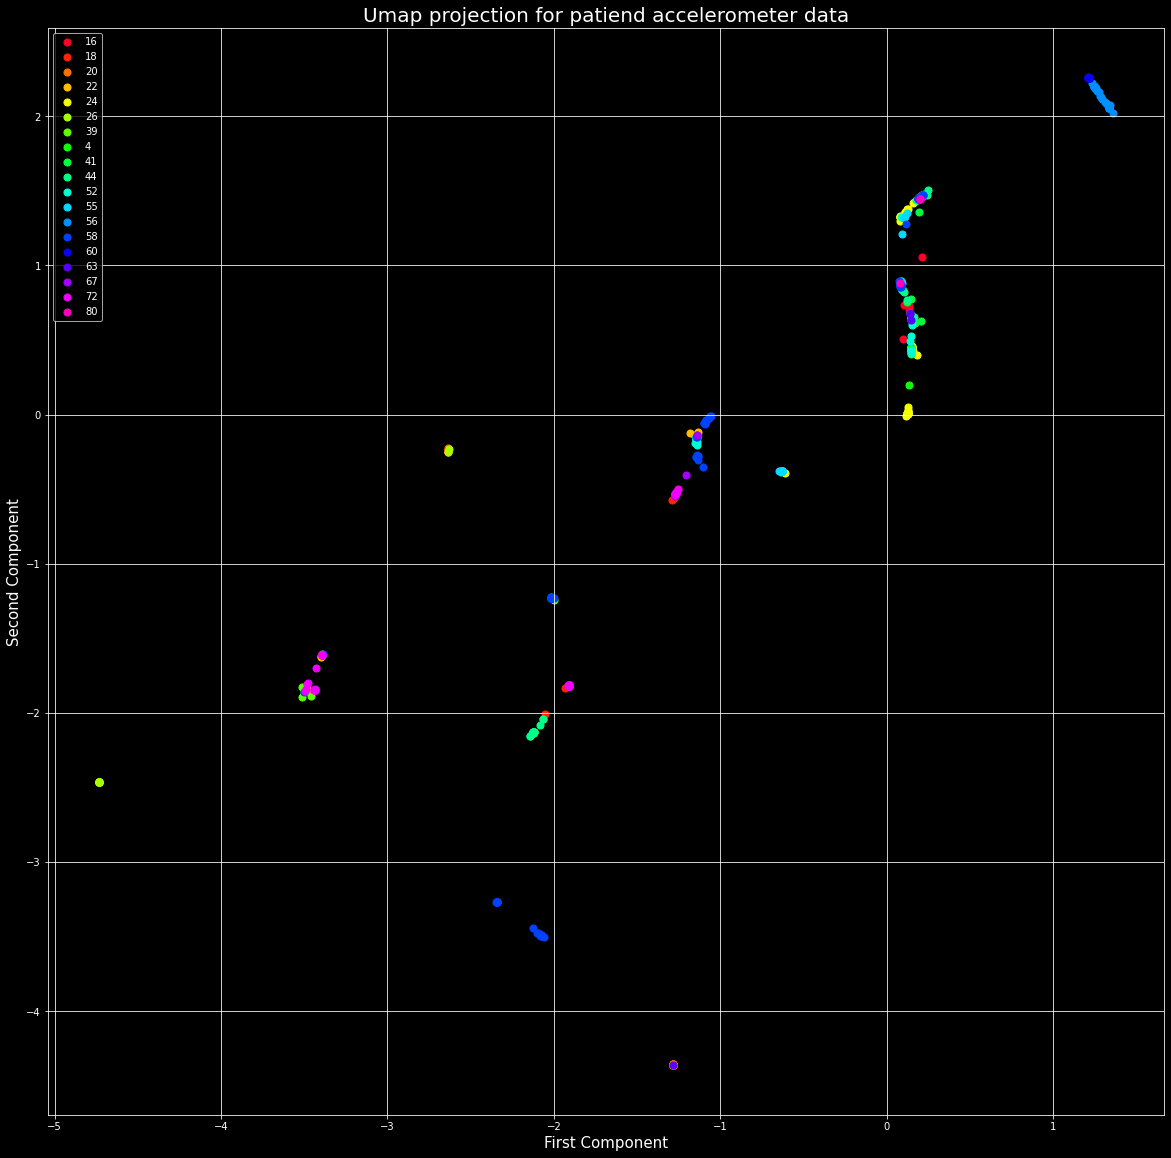

In [33]:
exp_name = 'umap_handcrafted_features_clustering_hdbscan_cluster_2'
print_one_cluster(finalDf, exp_name, 2)